# Assignment 3


# Step 1: Import Libraries and Load Data

In [320]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# File paths
data_path = "/Users/overwatch/Desktop/University Documents/My Classes Docs/Data Fusion Architecture/final assignments/assignment 3/DFA_Assignment3_data/"
imu_file = data_path + "imu_data.csv"
mouse_file = data_path + "mouse_data.csv"
tf_file = data_path + "tf_data.csv"
wheel_status_file = data_path + "wheel_status_data.csv"
wheel_ticks_file = data_path + "wheel_ticks_data.csv"
wheel_vels_file = data_path + "wheel_vels_data.csv"

# Load data
imu_data = pd.read_csv(imu_file)
mouse_data = pd.read_csv(mouse_file)
tf_data = pd.read_csv(tf_file)
wheel_status_data = pd.read_csv(wheel_status_file)
wheel_ticks_data = pd.read_csv(wheel_ticks_file)
wheel_vels_data = pd.read_csv(wheel_vels_file)

# Explore data
print("IMU Data:\n", imu_data.head())
print("Mouse Data:\n", mouse_data.head())
print("TF Data (Ground Truth):\n", tf_data.head())
print("Wheel Status:\n", wheel_status_data.head())
print("Wheel Ticks:\n", wheel_ticks_data.head())
print("Wheel Velocities:\n", wheel_vels_data.head())

IMU Data:
    timestamp_sec  timestamp_nanosec  orientation_x  orientation_y  \
0   1.701439e+09        872574508.0      -0.001259       0.000077   
1   1.701439e+09        972662066.0      -0.001235       0.000144   
2   1.701439e+09         34698611.0      -0.001234       0.000143   
3   1.701439e+09         82910864.0      -0.001235       0.000142   
4   1.701439e+09        132663916.0      -0.001236       0.000140   

   orientation_z  orientation_w  angular_velocity_x  angular_velocity_y  \
0      -0.000149       0.999999           -0.000270            0.000050   
1      -0.000149       0.999999            0.000029            0.000026   
2      -0.000149       0.999999            0.000045           -0.000024   
3      -0.000149       0.999999           -0.000011           -0.000066   
4      -0.000149       0.999999           -0.000074           -0.000108   

   angular_velocity_z  linear_acceleration_x  linear_acceleration_y  \
0        4.045142e-08              -0.038065        

# Step 2: Preprocess IMU Data

In [321]:
# Compute yaw from orientation quaternion
imu_data['yaw'] = np.arctan2(
    2.0 * (imu_data['orientation_w'] * imu_data['orientation_z'] +
           imu_data['orientation_x'] * imu_data['orientation_y']),
    1.0 - 2.0 * (imu_data['orientation_y']**2 + imu_data['orientation_z']**2)
)

# Compute delta_yaw using angular velocity and time step
imu_data['timestamp'] = imu_data['timestamp_sec'] + imu_data['timestamp_nanosec'] * 1e-9
imu_data['dt'] = imu_data['timestamp'].diff().fillna(0)
imu_data['delta_yaw'] = imu_data['angular_velocity_z'] * imu_data['dt']

# Step 3: Kalman Filter Implementation
# Kalman Filter Class

In [322]:
class KalmanFilter:
    def __init__(self, A, B, H, Q, R, P):
        self.A = A  # State transition matrix
        self.B = B  # Control matrix
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.P = P  # Estimation error covariance
        self.x = np.zeros((A.shape[0], 1))  # Initial state estimate

    def predict(self, u):
        self.x = np.dot(self.A, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q

    def update(self, z):
        y = z - np.dot(self.H, self.x)  # Innovation
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R  # Innovation covariance
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  # Kalman gain
        self.x += np.dot(K, y)  # Update state estimate
        self.P = self.P - np.dot(K, np.dot(self.H, self.P))

# Kalman Filter for IMU Yaw Smoothing

In [323]:
# Define Kalman filter parameters
dt = 0.1  # Time step
A = np.array([[1]])
B = np.array([[dt]])
H = np.array([[1]])
Q = np.array([[0.01]])  # Process noise covariance
R = np.array([[0.1]])  # Measurement noise covariance
P = np.array([[1]])  # Initial estimation error covariance

kf = KalmanFilter(A, B, H, Q, R, P)

# Preprocess IMU yaw data with Kalman filter
imu_data['filtered_yaw'] = 0  # Initialize filtered yaw column

for i in range(1, len(imu_data)):
    u = np.array([[imu_data['angular_velocity_z'].iloc[i]]])  # Control input
    z = np.array([[imu_data['yaw'].iloc[i]]])  # Observation
    kf.predict(u)  # Prediction step
    kf.update(z)  # Update step
    imu_data.at[i, 'filtered_yaw'] = kf.x[0, 0]  # Store filtered yaw

# Step 4: Initialize Particles

In [324]:
def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = np.random.uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = np.random.uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = np.random.uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi  # Normalize headings
    return particles

N = 5000
particles = create_uniform_particles((0, 3), (0, 3), (0, 2 * np.pi), N)
weights = np.ones(N) / N

# Step 5: Motion Model

In [325]:
def motion_model(particles, u, std, dt=1.0):
    dx, dy, dtheta = u
    noise = np.random.normal(0, std, particles.shape)
    particles[:, 0] += (dx * np.cos(particles[:, 2]) - dy * np.sin(particles[:, 2])) * dt + noise[:, 0]
    particles[:, 1] += (dx * np.sin(particles[:, 2]) + dy * np.cos(particles[:, 2])) * dt + noise[:, 1]
    particles[:, 2] += dtheta * dt + noise[:, 2]
    particles[:, 2] %= 2 * np.pi  # Normalize heading
    return particles

# Step 6: Update Weights

In [326]:
def update_weights(particles, weights, z, landmarks, R):
    for i, landmark in enumerate(landmarks):
        distances = np.linalg.norm(particles[:, :2] - landmark, axis=1)
        weights *= norm.pdf(z[i], distances, R)
    weights += 1.e-300  # Avoid zero weights
    weights /= np.sum(weights)  # Normalize
    return weights

landmarks = np.array([[0.5, 0.5], [2.5, 2.5], [1.5, 1.5]])
observed_distances = np.linalg.norm(landmarks - np.array([1.0, 1.0]), axis=1)
weights = update_weights(particles, weights, observed_distances, landmarks, R=0.2)

# Step 7: Resampling

In [327]:
def systematic_resample(weights):
    N = len(weights)
    positions = (np.random.random() + np.arange(N)) / N
    cumulative_sum = np.cumsum(weights)
    indexes = np.zeros(N, dtype=int)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

def resample(particles, weights):
    indexes = systematic_resample(weights)
    particles[:] = particles[indexes]
    weights.fill(1.0 / len(weights))

# Step 8: Estimation

In [328]:
def estimate(particles, weights):
    pos = particles[:, :2]
    mean = np.average(pos, weights=weights, axis=0)
    var = np.average((pos - mean) ** 2, weights=weights, axis=0)
    return mean, var

mean, var = estimate(particles, weights)
print(f"Estimated Position: {mean}, Variance: {var}")

Estimated Position: [1.00800233 0.99713372], Variance: [0.06579484 0.06808369]


# Step 9: Main Loop

In [329]:
std = [0.1, 0.1, 0.05]
estimated_positions = []

for i in range(len(imu_data)):
    dtheta = imu_data['filtered_yaw'].iloc[i]
    dx = 0  # Placeholder
    dy = 0  # Placeholder
    particles = motion_model(particles, (dx, dy, dtheta), std)
    weights = update_weights(particles, weights, observed_distances, landmarks, R=0.2)
    if (1.0 / np.sum(weights**2)) < N / 2:
        resample(particles, weights)
    mean, _ = estimate(particles, weights)
    estimated_positions.append(mean)

# Step 10: Visualization

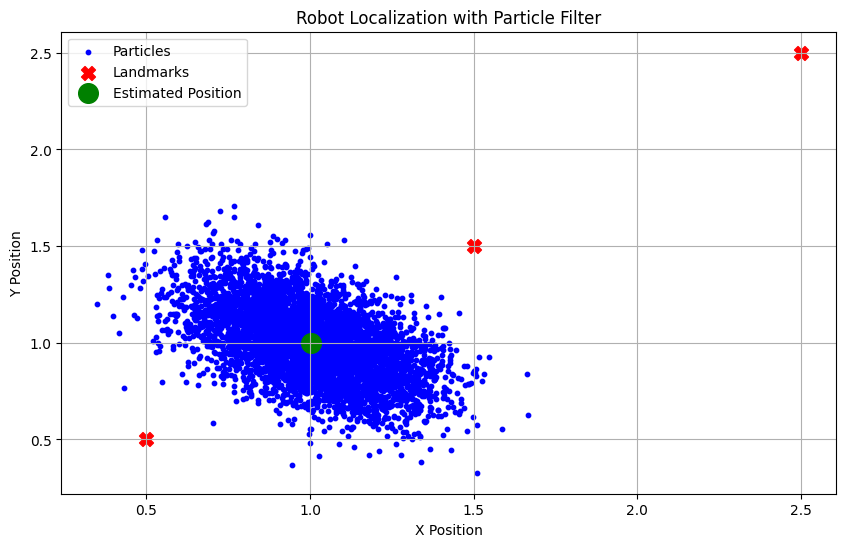

In [330]:
plt.figure(figsize=(10, 6))
plt.scatter(particles[:, 0], particles[:, 1], c='b', s=10, label="Particles")
plt.scatter(landmarks[:, 0], landmarks[:, 1], c='r', s=100, marker='X', label="Landmarks")
plt.scatter(mean[0], mean[1], c='g', s=200, marker='o', label="Estimated Position")
plt.title("Robot Localization with Particle Filter")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
plt.legend()
plt.show()

# Visualization of Kalman Filter Development

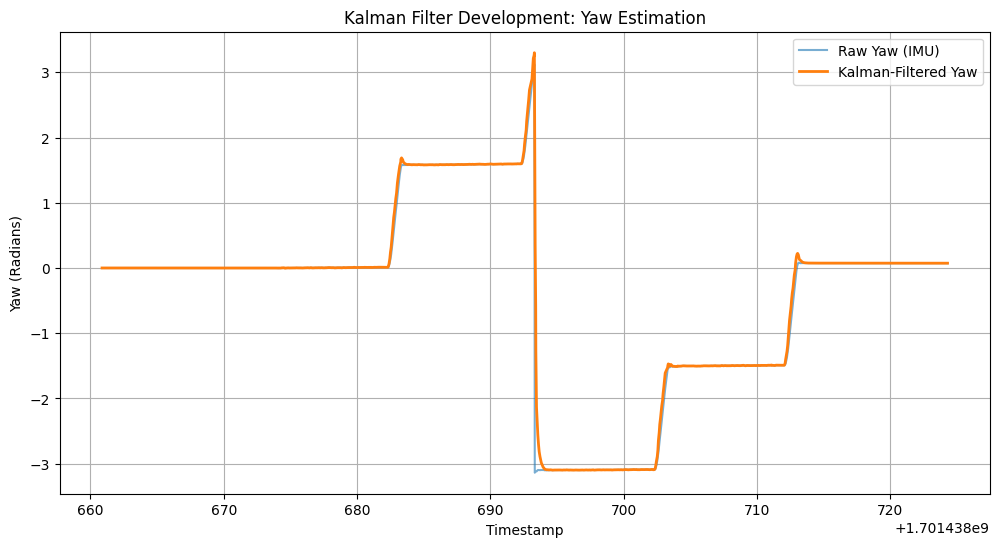

In [331]:
# Visualization of Kalman filter for yaw
plt.figure(figsize=(12, 6))

# Plot raw yaw values
plt.plot(imu_data['timestamp'], imu_data['yaw'], label='Raw Yaw (IMU)', alpha=0.6)

# Plot Kalman-filtered yaw values
plt.plot(imu_data['timestamp'], imu_data['filtered_yaw'], label='Kalman-Filtered Yaw', linewidth=2)

# Optional: Plot ground truth yaw if available
if 'ground_truth_yaw' in tf_data.columns:
    plt.plot(tf_data['timestamp'], tf_data['ground_truth_yaw'], label='Ground Truth Yaw', linestyle='dashed', linewidth=2)

# Add labels and legend
plt.title("Kalman Filter Development: Yaw Estimation")
plt.xlabel("Timestamp")
plt.ylabel("Yaw (Radians)")
plt.legend()
plt.grid(True)
plt.show()

# final step : Model Evaluation

RMSE (X-axis): 1.050 meters
RMSE (Y-axis): 0.824 meters
Total RMSE: 1.335 meters


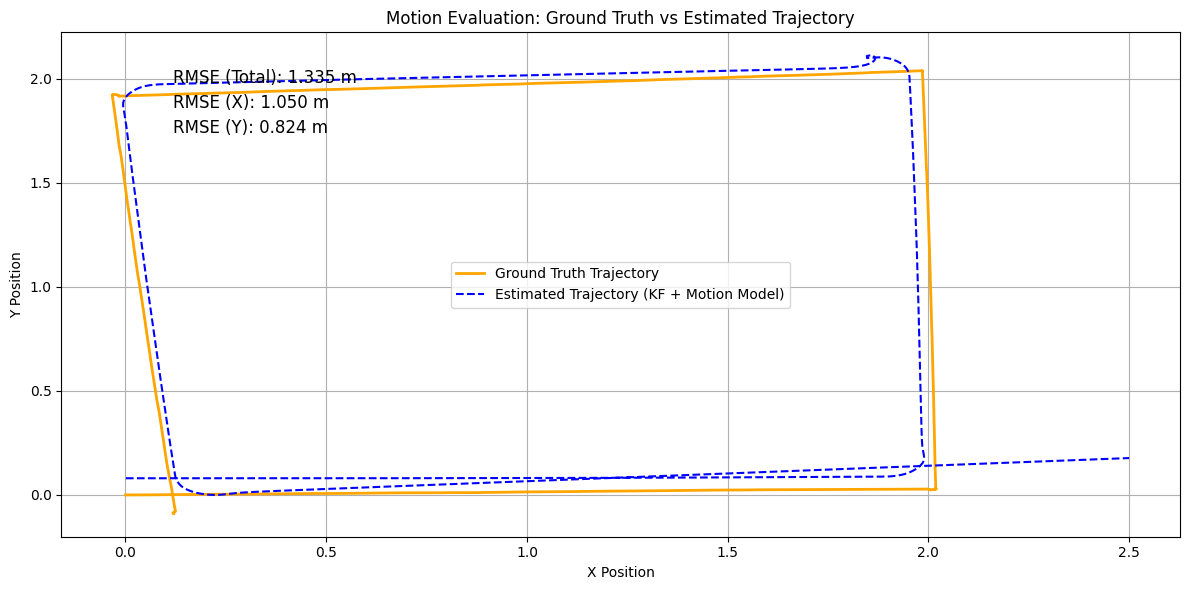

In [332]:
#  both trajectories have the same number of entries
min_length = min(len(ground_truth_positions), len(kf_shifted))
ground_truth_positions_trimmed = ground_truth_positions[:min_length]
kf_positions_trimmed = kf_shifted[:min_length]

# Compute RMSE
rmse_x = np.sqrt(np.mean((ground_truth_positions_trimmed[:, 0] - kf_positions_trimmed[:, 0]) ** 2))
rmse_y = np.sqrt(np.mean((ground_truth_positions_trimmed[:, 1] - kf_positions_trimmed[:, 1]) ** 2))
rmse_total = np.sqrt(rmse_x ** 2 + rmse_y ** 2)

# Display RMSE results
print(f"RMSE (X-axis): {rmse_x:.3f} meters")
print(f"RMSE (Y-axis): {rmse_y:.3f} meters")
print(f"Total RMSE: {rmse_total:.3f} meters")

# Plot ground truth vs estimated trajectory
plt.figure(figsize=(12, 6))

# Plot ground truth trajectory
plt.plot(ground_truth_positions_trimmed[:, 0], ground_truth_positions_trimmed[:, 1], 
         label='Ground Truth Trajectory', linewidth=2, color='orange')

# Plot estimated trajectory
plt.plot(kf_positions_trimmed[:, 0], kf_positions_trimmed[:, 1], 
         label='Estimated Trajectory (KF + Motion Model)', linestyle='dashed', color='blue')

# Add RMSE annotations
plt.text(0.1, 0.9, f'RMSE (Total): {rmse_total:.3f} m', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.85, f'RMSE (X): {rmse_x:.3f} m', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.8, f'RMSE (Y): {rmse_y:.3f} m', fontsize=12, transform=plt.gca().transAxes)

# Add labels and legend
plt.title("Motion Evaluation: Ground Truth vs Estimated Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()